In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import keras.optimizers as optimizers

In [2]:
%matplotlib inline
plt.style.use('seaborn')

## 1. Load and Prepare Datasets

In [3]:
_DIR = "cells/cell.csv"
data = pd.read_csv(_DIR)
data["Index"] = data.index
identifiers = ["ImageNumber", "ObjectNumber"]
matches = ["AreaShape", "Neighbors"]
all_features = [feature for feature in data.columns if any(match in feature for match in matches)]
all_features = [feature for feature in all_features if not data[feature].isnull().values.any()]
with open("metadata/all_features.txt", "w") as f:
    for feat in all_features:
        f.write(feat + "\n")

cell_identities = pd.read_csv("identities/populations.csv")
cell_identities = cell_identities.drop(["Unnamed: 0"], axis=1)
labelled_data = pd.merge(data, cell_identities, left_on="Index", right_on="Master_Index")
log_regr_target = "population"
all_columns = all_features + [log_regr_target]
labelled_data = labelled_data[all_columns]
labelled_data = labelled_data.dropna()
labelled_data = labelled_data[labelled_data.population != "Unclear"]

In [4]:
x = labelled_data[all_features]
y = labelled_data[log_regr_target]
all_populations = y.unique()
with open("metadata/all_populations.txt", "w") as file:
    for population in all_populations:
        file.write(population + "\n")

## 2. Principal Component Analysis

### 2.1. Cumulative Explained Variance

In [13]:
# Find the cumulative explained variance for different total number of PCs
pca = PCA()
x_pc = pca.fit_transform(scale(x))
exp_var = pca.explained_variance_ratio_
cs_eigens = np.cumsum(exp_var)
for eigen, idx in zip(cs_eigens, range(0,len(cs_eigens))):
    if eigen >= 0.99:
        print(f"{idx+1} principal components explain {round(eigen*100,1)}% of the variance")
        break

66 principal components explain 99.0% of the variance


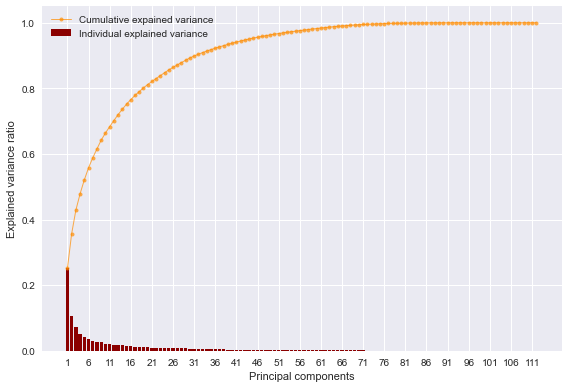

In [6]:
plt.bar(
    range(1,len(exp_var)+1),
    exp_var,
    alpha=1,
    align="center",
    label="Individual explained variance",
    color='darkred'
)
plt.plot(
    range(1,len(cs_eigens)+1),
    cs_eigens,
    "-o",
    alpha=0.7,
    label="Cumulative expained variance",
    markersize=4,
    linewidth=1,
    c='darkorange'
)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1, len(exp_var), step=5), np.arange(1, len(exp_var)+1, step=5))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### 2.1.1. Set an ~optimal number of principal components for downstream models

In [5]:
n_components = 71

#### 2.1.2. Identify which explanatory variables make up each principal component

In [6]:
def get_n_largest(df, n):
    n_largest_vars = {}
    n_largest_vals = {}
    for n_ in range(1, n+1):
        n_largest_vars[n_] = []
        n_largest_vals[n_] = []

    def find_n_largest(row):
        abs_vals = row.abs()
        sorted_vals = abs_vals.sort_values(axis=0, ascending=False)
        for x in range(0, n):
            n_max_abs_var = sorted_vals[sorted_vals == sorted_vals[x]]
            n_max_var = n_max_abs_var.index[0]
            n_max_val = row[n_max_var]
            n_largest_vars[x+1].append(n_max_var)
            n_largest_vals[x+1].append(n_max_val)

    df.apply(
        lambda row: find_n_largest(row),
        axis=1
    )

    n_largest = pd.DataFrame(index=df.index)
    for n_ in range(1, n+1):
        n_largest[str(n_)+"_largest_var"] = n_largest_vars[n_] 
        n_largest[str(n_)+"_largest_val"] = n_largest_vals[n_]

    return n_largest

In [8]:
pc_exp = pd.DataFrame(
    pca.components_,
    columns=all_features,
    index = [
        "PC-"+str(x) 
        for x in range(1, len(pca.get_feature_names_out())+1)
    ]
)
pc_exp.to_csv("outputs/PC_constituents_all.csv")
pc_exp = get_n_largest(pc_exp, 5)
pc_exp.to_csv("outputs/PC_constituents_largest.csv")

### 2.2. PC1 vs PC2

Text(0, 0.5, 'Principal Component 2')

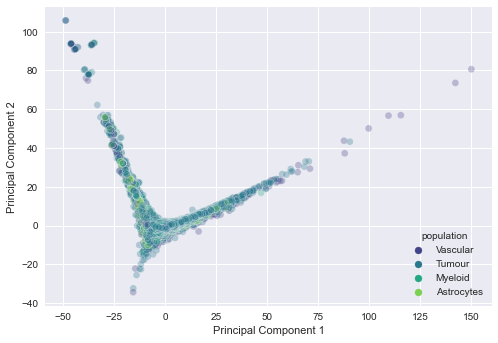

In [8]:
plt.figure()
sns.scatterplot(
    x=x_pc[:, 0], y=x_pc[:, 1],
    hue=y,
    palette=sns.color_palette("viridis", len(y.unique())),
    legend="full",
    alpha=0.3
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## 3. T-distributed Stochastic Neighbor Embedding

In [7]:
tsne = TSNE(
    n_components=2, 
    verbose=1, 
    perplexity=50, 
    n_iter=300
)
tsne_results = tsne.fit_transform(x_pc[:,:n_components])

c:\Users\tjoos\Desktop\RP2\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\tjoos\Desktop\RP2\venv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 194584 samples in 0.091s...
[t-SNE] Computed neighbors for 194584 samples in 92.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 194584
[t-SNE] Computed conditional probabilities for sample 2000 / 194584
[t-SNE] Computed conditional probabilities for sample 3000 / 194584
[t-SNE] Computed conditional probabilities for sample 4000 / 194584
[t-SNE] Computed conditional probabilities for sample 5000 / 194584
[t-SNE] Computed conditional probabilities for sample 6000 / 194584
[t-SNE] Computed conditional probabilities for sample 7000 / 194584
[t-SNE] Computed conditional probabilities for sample 8000 / 194584
[t-SNE] Computed conditional probabilities for sample 9000 / 194584
[t-SNE] Computed conditional probabilities for sample 10000 / 194584
[t-SNE] Computed conditional probabilities for sample 11000 / 194584
[t-SNE] Computed conditional probabilities for sample 12000 / 194584
[t-SNE] Computed conditional proba

<AxesSubplot:>

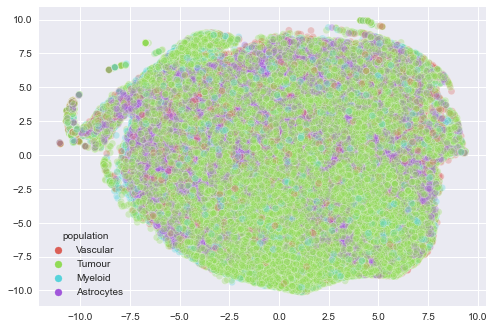

In [8]:
plt.figure()
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=y,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3,
)

## 4. Cell Population Distribution

<AxesSubplot:>

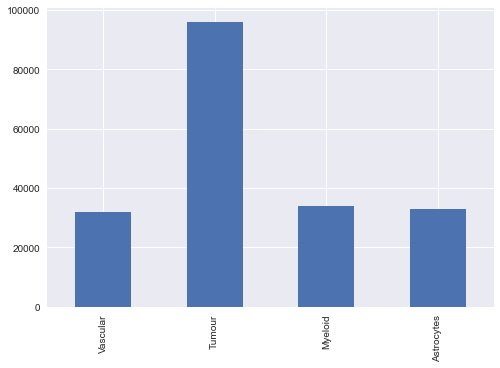

In [9]:
counts = Counter(labelled_data.population)
hist = pd.DataFrame.from_dict(counts, orient='index')
hist.plot(kind='bar', legend=None)

### 4.1. Equalize Population Numbers

In [7]:
def equalize(df, size):
    names = df.population.unique()
    to_combine = [
        df.population[df.population.eq(name)].sample(size).index
        for name in names
    ]
    combined = to_combine[0]
    for n in range(1, len(to_combine)):
        combined = to_combine[n].union(combined)
    df = df.loc[combined]
    return df

def rand_equalize(df, size, weights=[0.8, 0.95, 0.85, 0.90]):
    names = df.population.unique()
    num_pops = len(names)
    each_unique = False
    if num_pops == len(weights):
        each_unique = True
    to_combine = []
    for name in names:
        weight = np.random.choice(weights)
        if each_unique == True:
            weights.remove(weight)
        weighted_size = round(size*weight)
        idxs = df.population[df.population.eq(name)].sample(weighted_size).index
        to_combine.append(idxs)
    combined = to_combine[0]
    for n in range(1, len(to_combine)):
        combined = to_combine[n].union(combined)
    df = df.loc[combined]
    return df

## 5. Tumour Classification

### 5.1. Data Preparation

In [11]:
binary_converter = {
        "Tumour": 1,
        "Myeloid": 0,
        "Astrocytes": 0,
        "Vascular": 0,
    }

In [8]:
def prep_binary_classif_data(labelled_data, all_features, n_components, binary_converter):
    labelled_data_binary = labelled_data.copy()
    labelled_data_binary.population = labelled_data_binary.population.map(binary_converter)
    binary_counts = Counter(labelled_data_binary.population)
    labelled_data_binary = equalize(labelled_data_binary, min(binary_counts.values()))
    binary_counts_new = Counter(labelled_data_binary.population)
    hist_binary = pd.DataFrame.from_dict(binary_counts_new, orient='index')
    y = labelled_data_binary.population
    x = labelled_data_binary[all_features]
    if n_components != 0:
        hist_binary.plot(kind='bar', legend=None)
        pca = PCA()
        x = pca.fit_transform(scale(x))[:,:n_components]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        x_train_scaled = scale(x_train)
        return x_train_scaled, x_test, y_train, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

### 5.2. Binary Logistic Regression

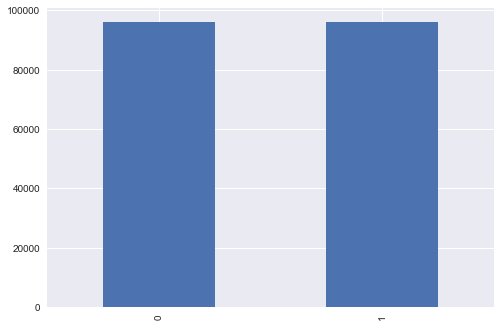

In [13]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, binary_converter)

In [14]:
log_regr = LogisticRegression(
    random_state=42, 
    solver="lbfgs", 
    C=10.0, 
    max_iter=1000
)
log_regr = log_regr.fit(x_train_scaled, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
log_regr_score_train = cross_val_score(
    log_regr, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross-validation score (mean prediction accuracy): {log_regr_score_train}")

Cross-validation score (mean prediction accuracy): 0.6128288003083215


Prediction accuracy on test data: 0.5968670993301535


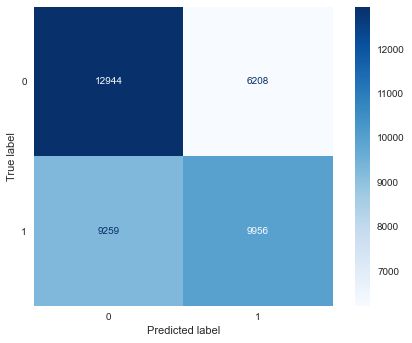

              precision    recall  f1-score   support

           0       0.58      0.68      0.63     19152
           1       0.62      0.52      0.56     19215

    accuracy                           0.60     38367
   macro avg       0.60      0.60      0.59     38367
weighted avg       0.60      0.60      0.59     38367



In [15]:
y_pred = log_regr.predict(x_test)
y_pred_score = log_regr.score(x_test, y_test)
print(f"Prediction accuracy on test data: {y_pred_score}")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=log_regr.classes_,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred))

In [23]:
def rank_pc_coeffs(coeffs):
    pc_coeffs = {}
    for coeff in coeffs:
        pc_name = "PC" + "-" + str(coeffs.index(coeff)+1) 
        pc_coeff = str(round(coeff, 10))
        pc_coeffs[pc_name] = pc_coeff
    pc_coeffs = pd.DataFrame(pc_coeffs.items(), columns=["Principal Component", "Coefficient"])
    pc_coeffs = pc_coeffs.sort_values(by="Coefficient", ascending=False)
    return pc_coeffs

In [23]:
coeffs = log_regr.coef_
coeffs = coeffs.tolist()[0]
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_1.csv")

   Principal Component    Coefficient                          1_largest_var  \
54               PC-55   0.1844411259  Neighbors_SecondClosestObjectNumber_8   
31               PC-32   0.1760243536          Neighbors_NumberOfNeighbors_8   
2                 PC-3   0.1383979488                   AreaShape_HuMoment_0   
1                 PC-2   0.1030978084                  AreaShape_Zernike_6_0   
0                 PC-1   0.0993360201                   AreaShape_ConvexArea   
..                 ...            ...                                    ...   
66               PC-67   -0.003918795            AreaShape_CentralMoment_2_2   
58               PC-59  -0.0037439828      Neighbors_SecondClosestDistance_8   
48               PC-49  -0.0037071347         AreaShape_NormalizedMoment_2_2   
51               PC-52  -0.0026523335                  AreaShape_Zernike_9_1   
52               PC-53  -0.0014417423                  AreaShape_Zernike_7_3   

    1_largest_val                      

### 5.3. Artificial Neural Network

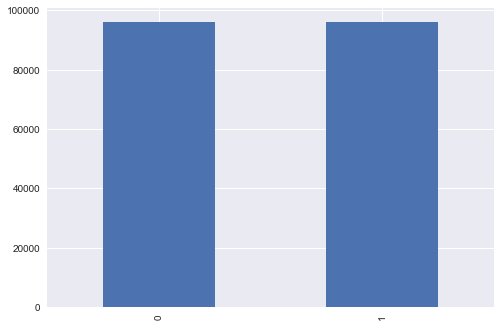

In [24]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, binary_converter)

In [8]:
def categorize_y_vars(*args):
    Y = (
        np_utils.to_categorical(LabelEncoder().fit(y).transform(y))
        for y in args
    )
    return Y

In [26]:
y_train, y_test = categorize_y_vars(y_train, y_test)

In [31]:
vars = x_train_scaled.shape[1]
out=len(np.unique(y_train))
n_hidden_layers = 2
n_hidden_neurons = 2/3*vars+out
n_hidden_per_layer = n_hidden_neurons/n_hidden_layers

model = Sequential()
model.add(Dense(n_hidden_per_layer, input_shape=(vars,), activation='relu'))
model.add(Dense(n_hidden_per_layer))
model.add(Dense(out, activation='softmax'))
model.summary()

opt = optimizers.SGD(learning_rate=0.01, clipvalue=0.5)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max',
                   patience=10,
                   restore_best_weights=True)

hist = model.fit(x_train_scaled,
                 y_train,
                 callbacks=[es],
                 epochs=100,
                 batch_size=16,
                 validation_split=0.2,
                 shuffle=True,
                 verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                1728      
                                                                 
 dense_13 (Dense)            (None, 24)                600       
                                                                 
 dense_14 (Dense)            (None, 2)                 50        
                                                                 
Total params: 2,378
Trainable params: 2,378
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7674/7674 [==============================] - 26s 3ms/step - loss: 0.6625 - accuracy: 0.6019 - val_loss: 0.6509 - val_accuracy: 0.6125
Epoch 2/100
7674/7674 [==============================] - 25s 3ms/step - loss: 0.6485 - accuracy: 0.6154 - val_loss: 0.6484 - val_accuracy: 0.6167
Epoch 3/100
7674/7674 [=

In [32]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

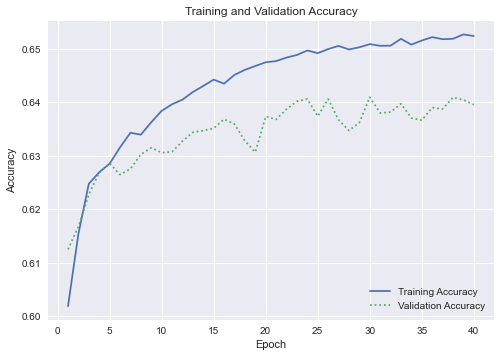

In [33]:
show_history(hist)

1199/1199 [==============================] - 1s 655us/step
Prediction accuracy on test data: 0.566189694268512


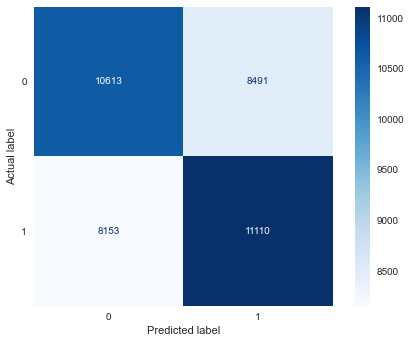

In [37]:
nn_pred = model.predict(x_test)
acc = accuracy_score(y_test.argmax(axis=1), nn_pred.argmax(axis=1))
print(f"Prediction accuracy on test data: {acc}")

mat = confusion_matrix(
    y_test.argmax(axis=1),
    nn_pred.argmax(axis=1))

labels = np.unique(y_train).astype(int)
disp = ConfusionMatrixDisplay(
    confusion_matrix=mat, 
    display_labels=labels,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

### 5.4. Random Forest Classifier

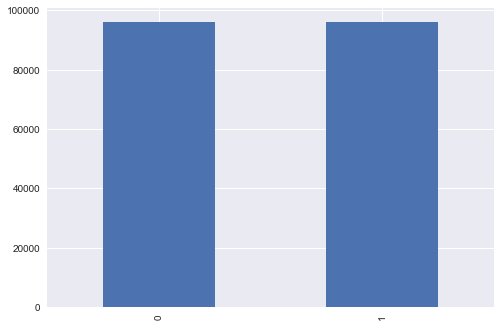

In [35]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, binary_converter)
y_train, y_test = categorize_y_vars(y_train, y_test)

In [39]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train_scaled, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
rfc_score_train = cross_val_score(
    rfc, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross-validation score (mean prediction accuracy): {rfc_score_train}")

Cross-validation score (mean prediction accuracy): 0.590166012397118


Prediction accuracy on test data: 0.588187765527667


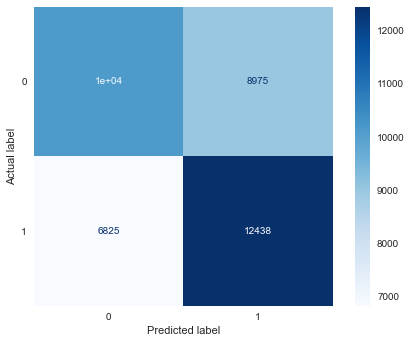

In [40]:
rfc_pred = rfc.predict(x_test)
acc = accuracy_score(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
print(f"Prediction accuracy on test data: {acc}")

mat_rfc = confusion_matrix(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
labels = np.unique(y_train).astype(int)
disp = ConfusionMatrixDisplay(
    confusion_matrix=mat_rfc, 
    display_labels=labels,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [41]:
coeffs = rfc.feature_importances_.tolist()
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_3.csv")

   Principal Component   Coefficient                          1_largest_var  \
31               PC-32   0.025670552          Neighbors_NumberOfNeighbors_8   
56               PC-57  0.0239396922   Neighbors_FirstClosestObjectNumber_8   
54               PC-55   0.021801509  Neighbors_SecondClosestObjectNumber_8   
12               PC-13  0.0212937896          Neighbors_NumberOfNeighbors_8   
4                 PC-5  0.0174725803                     AreaShape_Center_Y   
..                 ...           ...                                    ...   
11               PC-12  0.0124818241         AreaShape_NormalizedMoment_2_0   
29               PC-30  0.0124191759         AreaShape_NormalizedMoment_0_3   
17               PC-18  0.0124032026         AreaShape_NormalizedMoment_3_0   
65               PC-66  0.0122842624            AreaShape_CentralMoment_2_1   
3                 PC-4  0.0122605581            AreaShape_InertiaTensor_1_0   

    1_largest_val                          2_larges

## 6. Multiclass Classification

### 6.1. Data Preparation

In [42]:
def prep_multi_classif_data(labelled_data, all_features, n_components):
    labelled_data_multiclass = labelled_data.copy()
    multiclass_counts = Counter(labelled_data_multiclass.population)
    labelled_data_multiclass = equalize(labelled_data_multiclass, min(multiclass_counts.values()))
    multiclass_counts_new = Counter(labelled_data_multiclass.population)
    hist_multi = pd.DataFrame.from_dict(multiclass_counts_new, orient='index')
    hist_multi.plot(kind='bar', legend=None)
    y = labelled_data_multiclass.population
    x = labelled_data_multiclass[all_features]
    pca = PCA()
    x = pca.fit_transform(scale(x))[:,:n_components]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train_scaled = scale(x_train)
    return x_train_scaled, x_test, y_train, y_test

### 6.2. Multinomial Logistic Regression

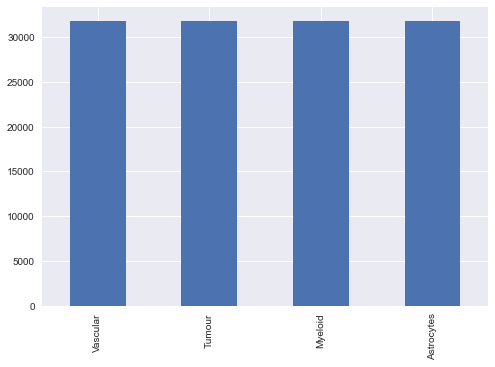

In [43]:
x_train_scaled, x_test, y_train, y_test = prep_multi_classif_data(labelled_data, all_features, n_components)

In [44]:
mlr = LogisticRegression(multi_class='multinomial', 
                         solver='lbfgs', 
                         C=10.0, 
                         max_iter=1000)
mlr.fit(x_train_scaled, y_train)
mlr_score_train = cross_val_score(
    mlr, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross validation (mean prediction accuracy): {mlr_score_train}")

Cross validation (mean prediction accuracy): 0.4775108451232713


Prediction accuracy on test data: 0.42414483760750893


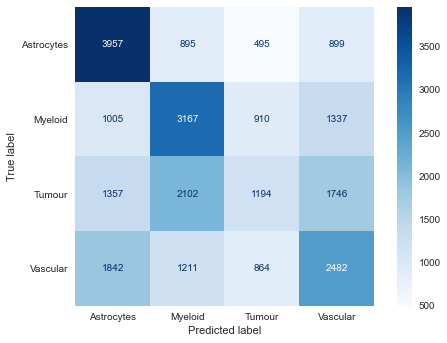

              precision    recall  f1-score   support

  Astrocytes       0.48      0.63      0.55      6246
     Myeloid       0.43      0.49      0.46      6419
      Tumour       0.34      0.19      0.24      6399
    Vascular       0.38      0.39      0.39      6399

    accuracy                           0.42     25463
   macro avg       0.41      0.43      0.41     25463
weighted avg       0.41      0.42      0.41     25463



In [45]:
mlr_pred = mlr.predict(x_test)
mlr_y_score = mlr.score(x_test, y_test)
print(f"Prediction accuracy on test data: {mlr_y_score}")
cm_mlr = confusion_matrix(y_test, mlr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlr, 
                              display_labels=mlr.classes_,)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()
print(classification_report(y_test, mlr_pred, zero_division=True))

In [46]:
coeffs = mlr.coef_
coeffs = coeffs.tolist()[0]
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_4.csv")

   Principal Component    Coefficient                      1_largest_var  \
59               PC-60   0.7792872502     AreaShape_NormalizedMoment_1_2   
12               PC-13   0.6382400038      Neighbors_NumberOfNeighbors_8   
39               PC-40   0.3817479598              AreaShape_Orientation   
40               PC-41   0.2978199506              AreaShape_Zernike_6_2   
10               PC-11    0.272448939     AreaShape_NormalizedMoment_2_1   
..                 ...            ...                                ...   
57               PC-58  -0.0138238411  Neighbors_SecondClosestDistance_8   
23               PC-24  -0.0112615487        AreaShape_CentralMoment_1_0   
21               PC-22  -0.0088075087        AreaShape_CentralMoment_1_0   
8                 PC-9  -0.0066056979     AreaShape_BoundingBoxMinimum_X   
52               PC-53  -0.0026022985              AreaShape_Zernike_7_3   

    1_largest_val                     2_largest_var  2_largest_val  \
59      -0.431237

### 6.3. Artificial Neural Network

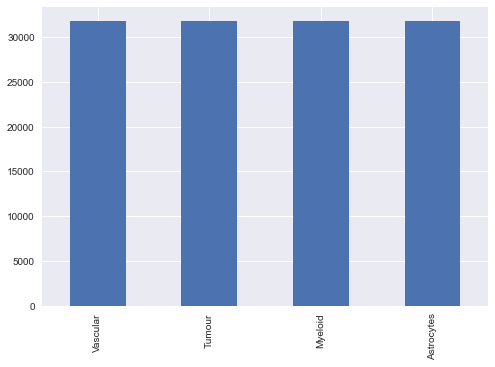

In [68]:
x_train_scaled, x_test, y_train, y_test = prep_multi_classif_data(labelled_data, all_features, n_components)
y_train, y_test = categorize_y_vars(y_train, y_test)

In [69]:
vars = x_train_scaled.shape[1]
outs = y_train.shape[1]
n_hidden_layers = 2
n_hidden_nodes = 2/3*vars+out
hidden_per_layer = n_hidden_nodes/n_hidden_layers

model = Sequential()
model.add(Dense(hidden_per_layer, input_dim=vars, activation='relu'))
model.add(Dense(hidden_per_layer))
model.add(Dense(4, activation='softmax'))
model.summary()

opt = optimizers.SGD(learning_rate=0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max',
                   patience=10,
                   restore_best_weights=True)

hist = model.fit(x_train_scaled,
                 y_train,
                 callbacks=[es],
                 epochs=100,
                 batch_size=16,
                 validation_split=0.2,
                 shuffle=True,
                 verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 24)                1728      
                                                                 
 dense_22 (Dense)            (None, 24)                600       
                                                                 
 dense_23 (Dense)            (None, 4)                 100       
                                                                 
Total params: 2,428
Trainable params: 2,428
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5093/5093 [==============================] - 16s 3ms/step - loss: 1.1776 - accuracy: 0.4650 - val_loss: 1.1346 - val_accuracy: 0.4857
Epoch 2/100
5093/5093 [==============================] - 16s 3ms/step - loss: 1.1117 - accuracy: 0.5093 - val_loss: 1.1096 - val_accuracy: 0.5081
Epoch 3/100
5093/5093 [=

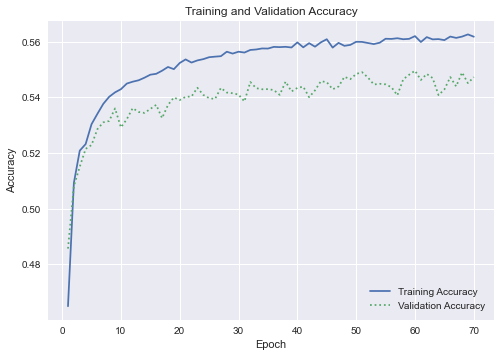

In [70]:
show_history(hist)

796/796 [==============================] - 1s 2ms/step
Prediction accuracy on test data: 0.3716372776185053


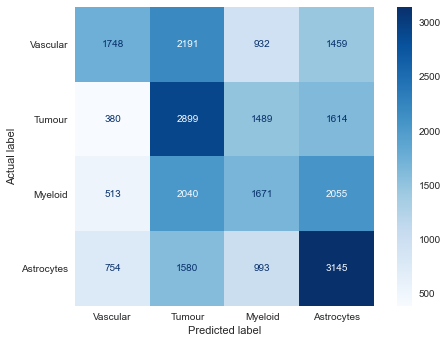

In [71]:
nn_pred = model.predict(x_test)
acc = accuracy_score(y_test.argmax(axis=1), nn_pred.argmax(axis=1))
print(f"Prediction accuracy on test data: {acc}")

mat = confusion_matrix(
    y_test.argmax(axis=1),
    nn_pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=mat, 
                              display_labels=all_populations,)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

### 6.4. Random Forest Classifier

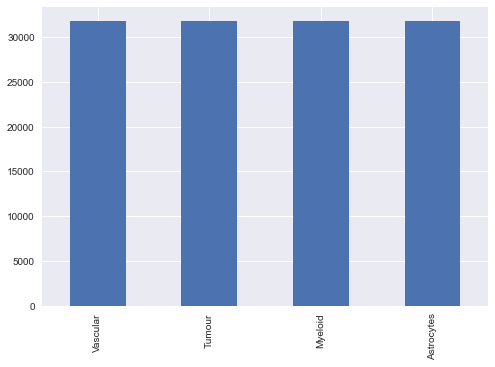

In [80]:
x_train_scaled, x_test, y_train, y_test = prep_multi_classif_data(labelled_data, all_features, n_components)
y_train, y_test = categorize_y_vars(y_train, y_test)

In [82]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train_scaled, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
rfc_score_train = cross_val_score(
    rfc, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross-validation score (mean prediction accuracy): {rfc_score_train}")

Cross-validation score (mean prediction accuracy): 0.11708513281973976


Prediction accuracy on test data: 0.27569414444488083


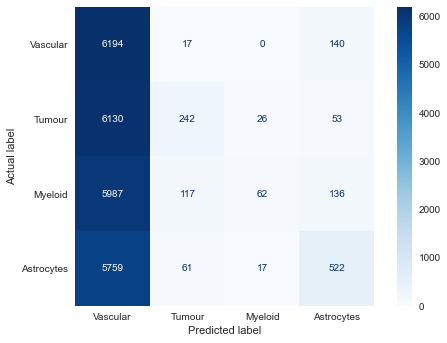

In [74]:
rfc_pred = rfc.predict(x_test)
acc = accuracy_score(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
print(f"Prediction accuracy on test data: {acc}")

mat_rfc = confusion_matrix(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
labels = y.unique()
disp = ConfusionMatrixDisplay(
    confusion_matrix=mat_rfc, 
    display_labels=labels,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [54]:
coeffs = rfc.feature_importances_.tolist()
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_6.csv")

   Principal Component   Coefficient                   1_largest_var  \
60               PC-61  0.0370823945           AreaShape_Zernike_9_3   
59               PC-60  0.0320346668  AreaShape_NormalizedMoment_1_2   
31               PC-32  0.0278558208   Neighbors_NumberOfNeighbors_8   
4                 PC-5  0.0201250842              AreaShape_Center_Y   
12               PC-13  0.0196835651   Neighbors_NumberOfNeighbors_8   
..                 ...           ...                             ...   
65               PC-66   0.011864233     AreaShape_CentralMoment_2_1   
3                 PC-4  0.0118357963     AreaShape_InertiaTensor_1_0   
17               PC-18  0.0117238133  AreaShape_NormalizedMoment_3_0   
28               PC-29  0.0117108373           AreaShape_Orientation   
39               PC-40  0.0116963663           AreaShape_Orientation   

    1_largest_val                   2_largest_var  2_largest_val  \
60      -0.434701           AreaShape_Zernike_7_5      -0.360666   

## 7. Astrocyte Classification

In [12]:
new_binary_converter = {
        "Tumour": 0,
        "Myeloid": 0,
        "Astrocytes": 1,
        "Vascular": 0,
    }

In [ ]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, new_binary_converter)

In [56]:
log_regr = LogisticRegression(
    random_state=42, 
    solver="lbfgs", 
    C=10.0, 
    max_iter=1000
)
log_regr = log_regr.fit(x_train_scaled, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
log_regr_score_train = cross_val_score(
    log_regr, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross-validation score (mean prediction accuracy): {log_regr_score_train}")

Cross-validation score (mean prediction accuracy): 0.7803765015280536


Prediction accuracy on test data: 0.7131322364411944


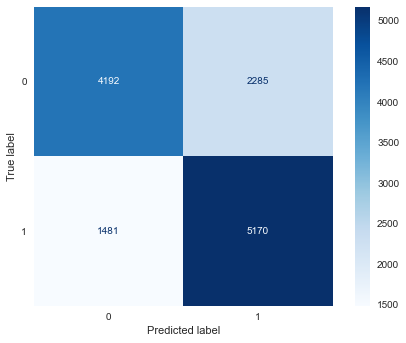

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      6477
           1       0.69      0.78      0.73      6651

    accuracy                           0.71     13128
   macro avg       0.72      0.71      0.71     13128
weighted avg       0.72      0.71      0.71     13128



In [57]:
y_pred = log_regr.predict(x_test)
y_pred_score = log_regr.score(x_test, y_test)
print(f"Prediction accuracy on test data: {y_pred_score}")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=log_regr.classes_,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred))

In [58]:
coeffs = log_regr.coef_
coeffs = coeffs.tolist()[0]
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_7.csv")

   Principal Component    Coefficient                   1_largest_var  \
61               PC-62   1.2556649594           AreaShape_Zernike_8_2   
12               PC-13   0.5125234139   Neighbors_NumberOfNeighbors_8   
13               PC-14   0.4910270651  AreaShape_NormalizedMoment_1_2   
39               PC-40   0.3953430712           AreaShape_Orientation   
16               PC-17   0.3522785203           AreaShape_Zernike_1_1   
..                 ...            ...                             ...   
50               PC-51   -0.005507099           AreaShape_Zernike_9_9   
34               PC-35   -0.005216649  AreaShape_NormalizedMoment_2_0   
46               PC-47   -0.002894384           AreaShape_Zernike_7_1   
42               PC-43  -0.0017133736            AreaShape_HuMoment_2   
68               PC-69  -0.0006083009            AreaShape_HuMoment_4   

    1_largest_val                   2_largest_var  2_largest_val  \
61       0.395826           AreaShape_Zernike_4_0      

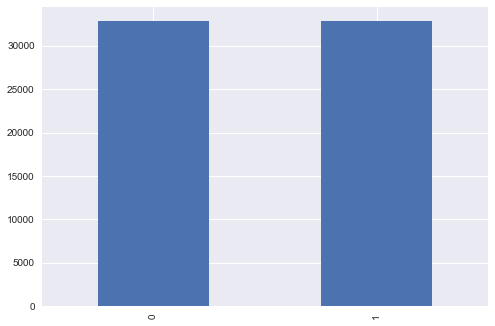

In [59]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, new_binary_converter)

In [60]:
y_train, y_test = categorize_y_vars(y_train, y_test)

In [61]:
vars = x_train_scaled.shape[1]
out=len(np.unique(y_train))
n_hidden_layers = 2
n_hidden_neurons = 2/3*vars+out
n_hidden_per_layer = n_hidden_neurons/n_hidden_layers

model = Sequential()
model.add(Dense(n_hidden_per_layer, input_shape=(vars,), activation='relu'))
model.add(Dense(n_hidden_per_layer))
model.add(Dense(out, activation='softmax'))
model.summary()

opt = optimizers.SGD(learning_rate=0.01, clipvalue=0.5)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                   mode='max',
                   patience=10,
                   restore_best_weights=True)

hist = model.fit(x_train_scaled,
                 y_train,
                 callbacks=[es],
                 epochs=100,
                 batch_size=16,
                 validation_split=0.2,
                 shuffle=True,
                 verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 24)                1728      
                                                                 
 dense_19 (Dense)            (None, 24)                600       
                                                                 
 dense_20 (Dense)            (None, 2)                 50        
                                                                 
Total params: 2,378
Trainable params: 2,378
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2626/2626 [==============================] - 5s 2ms/step - loss: 0.5094 - accuracy: 0.7592 - val_loss: 0.4830 - val_accuracy: 0.7716
Epoch 2/100
2626/2626 [==============================] - 6s 2ms/step - loss: 0.4666 - accuracy: 0.7882 - val_loss: 0.4761 - val_accuracy: 0.7793
Epoch 3/100
2626/2626 [===

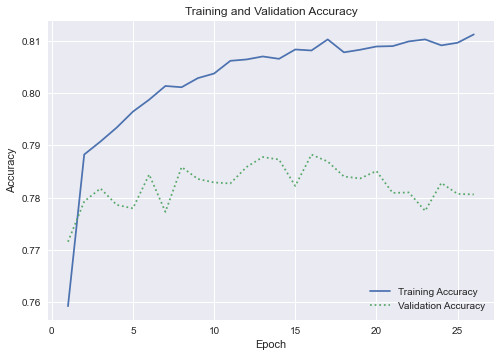

In [62]:
show_history(hist)

411/411 [==============================] - 1s 2ms/step
Prediction accuracy on test data: 0.7014015843997562


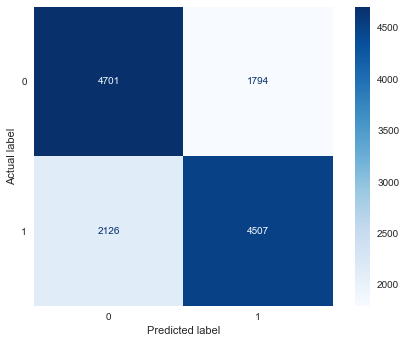

In [63]:
nn_pred = model.predict(x_test)
acc = accuracy_score(y_test.argmax(axis=1), nn_pred.argmax(axis=1))
print(f"Prediction accuracy on test data: {acc}")

mat = confusion_matrix(
    y_test.argmax(axis=1),
    nn_pred.argmax(axis=1))

labels = np.unique(y_train).astype(int)
disp = ConfusionMatrixDisplay(
    confusion_matrix=mat, 
    display_labels=labels,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

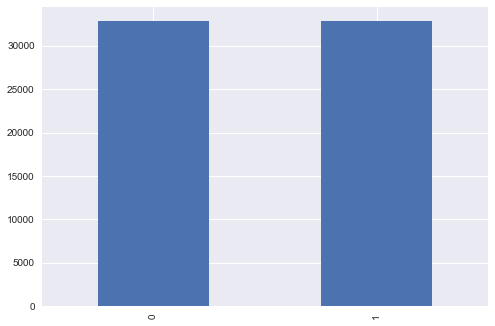

In [19]:
x_train_scaled, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, all_features, n_components, new_binary_converter)
y_train, y_test = categorize_y_vars(y_train, y_test)

In [20]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train_scaled, y_train)
cv = KFold(n_splits=10, shuffle=True, random_state=42)
rfc_score_train = cross_val_score(
    rfc, 
    x_train_scaled, 
    y_train,
    cv=cv
).mean()
print(f"Cross-validation score (mean prediction accuracy): {rfc_score_train}")

Cross-validation score (mean prediction accuracy): 0.7515618285859382


Prediction accuracy on test data: 0.6982784887263863


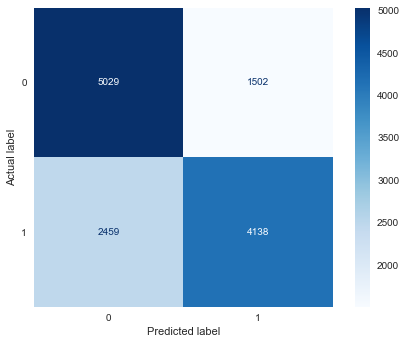

In [21]:
rfc_pred = rfc.predict(x_test)
acc = accuracy_score(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
print(f"Prediction accuracy on test data: {acc}")

mat_rfc = confusion_matrix(
    y_test.argmax(axis=1),
    rfc_pred.argmax(axis=1)
)
labels = np.unique(y_train).astype(int)
disp = ConfusionMatrixDisplay(
    confusion_matrix=mat_rfc, 
    display_labels=labels,
)
disp.plot(cmap="Blues")
plt.grid(False)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [24]:
coeffs = rfc.feature_importances_.tolist()
ranked_pc_coeffs = rank_pc_coeffs(coeffs)
ranked_vars = ranked_pc_coeffs.copy()

for col in pc_exp.columns:
    ranked_vars[col] = ranked_vars.apply(
        lambda row: pc_exp.loc[row[0]][col], axis=1
    )
print(ranked_vars)
ranked_vars.to_csv("outputs/Ranked_PCs_9.csv")

   Principal Component   Coefficient                      1_largest_var  \
62               PC-63    0.07997763              AreaShape_Zernike_8_2   
61               PC-62  0.0515368972              AreaShape_Zernike_8_2   
12               PC-13  0.0338431184      Neighbors_NumberOfNeighbors_8   
33               PC-34  0.0290519949              AreaShape_Zernike_5_1   
60               PC-61  0.0271675386              AreaShape_Zernike_9_3   
..                 ...           ...                                ...   
57               PC-58  0.0094631549  Neighbors_SecondClosestDistance_8   
47               PC-48  0.0093761492              AreaShape_Zernike_3_1   
19               PC-20  0.0093346031     AreaShape_NormalizedMoment_3_0   
24               PC-25  0.0093144001  Neighbors_AngleBetweenNeighbors_8   
29               PC-30  0.0091945897     AreaShape_NormalizedMoment_0_3   

    1_largest_val                     2_largest_var  2_largest_val  \
62       0.411383            

## 8. Univariate Analysis
##### Before performing an univariate analysis, the user must first run top_vars.ipynb to generate top_10_PCs.csv, which contains the top 10 unique principal components based upon a scoring system that considers importance across all models, and the top 3 explanatory variables for each principal component -- collectively this reveals the most important spatial parameters for cell identity classification.  

In [25]:
def get_vars_only(df):
    vars_only=[]
    def f(row):
        for n in range(3, len(row)-1):
            val = row[n]
            if "_" in str(val):
                vars_only.append(val)
    df.apply(
        lambda row: f(row),
        axis=1
    )
    return vars_only
    
univars_ = get_vars_only(
    pd.read_csv("outputs/top_10_PCs.csv")
)
univars = []
for univar in univars_:
    if univar not in univars:
        univars.append(univar)
print(univars)

['AreaShape_Zernike_8_2', 'AreaShape_Zernike_4_0', 'AreaShape_NormalizedMoment_3_3', 'AreaShape_HuMoment_1', 'AreaShape_Zernike_6_6', 'Neighbors_NumberOfNeighbors_8', 'Neighbors_PercentTouching_8', 'Neighbors_SecondClosestDistance_8', 'Neighbors_FirstClosestDistance_8', 'AreaShape_Zernike_3_1', 'AreaShape_Orientation', 'AreaShape_CentralMoment_1_3', 'AreaShape_InertiaTensor_0_1', 'AreaShape_InertiaTensor_1_0', 'AreaShape_NormalizedMoment_1_2', 'AreaShape_NormalizedMoment_3_2', 'AreaShape_CentralMoment_1_1', 'AreaShape_Extent', 'AreaShape_NormalizedMoment_2_2', 'AreaShape_NormalizedMoment_3_0']


In [26]:
def univar_regr(univar, labelled_data, binary_converter):
    x_train, x_test, y_train, y_test = prep_binary_classif_data(labelled_data, [univar], 0, binary_converter)
    log_regr = LogisticRegression(
        random_state=42, 
        solver="lbfgs", 
        C=10.0, 
        max_iter=1000
    )
    log_regr = log_regr.fit(x_train, y_train)
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    log_regr_score_train = cross_val_score(
        log_regr, 
        x_train, 
        y_train,
        cv=cv
    ).mean()
    print(f"Cross-validation score (mean prediction accuracy): {log_regr_score_train}")
    y_pred = log_regr.predict(x_test)
    y_pred_score = log_regr.score(x_test, y_test)
    print(f"Prediction accuracy on test data: {y_pred_score}")
    return log_regr, y_pred, y_test, log_regr_score_train, y_pred_score

VARIABLE: AreaShape_Zernike_8_2
---------------
Cross-validation score (mean prediction accuracy): 0.5060563593329162
Prediction accuracy on test data: 0.5104357099329677
---------------

VARIABLE: AreaShape_Zernike_4_0
---------------
Cross-validation score (mean prediction accuracy): 0.525138899620027
Prediction accuracy on test data: 0.5218616697135893
---------------

VARIABLE: AreaShape_NormalizedMoment_3_3
---------------
Cross-validation score (mean prediction accuracy): 0.48893473714757285
Prediction accuracy on test data: 0.4786715417428397
---------------

VARIABLE: AreaShape_HuMoment_1
---------------
Cross-validation score (mean prediction accuracy): 0.5395562024466994
Prediction accuracy on test data: 0.5407525898842169
---------------

VARIABLE: AreaShape_Zernike_6_6
---------------
Cross-validation score (mean prediction accuracy): 0.49535283800817986
Prediction accuracy on test data: 0.49657221206581353
---------------

VARIABLE: Neighbors_NumberOfNeighbors_8
----------

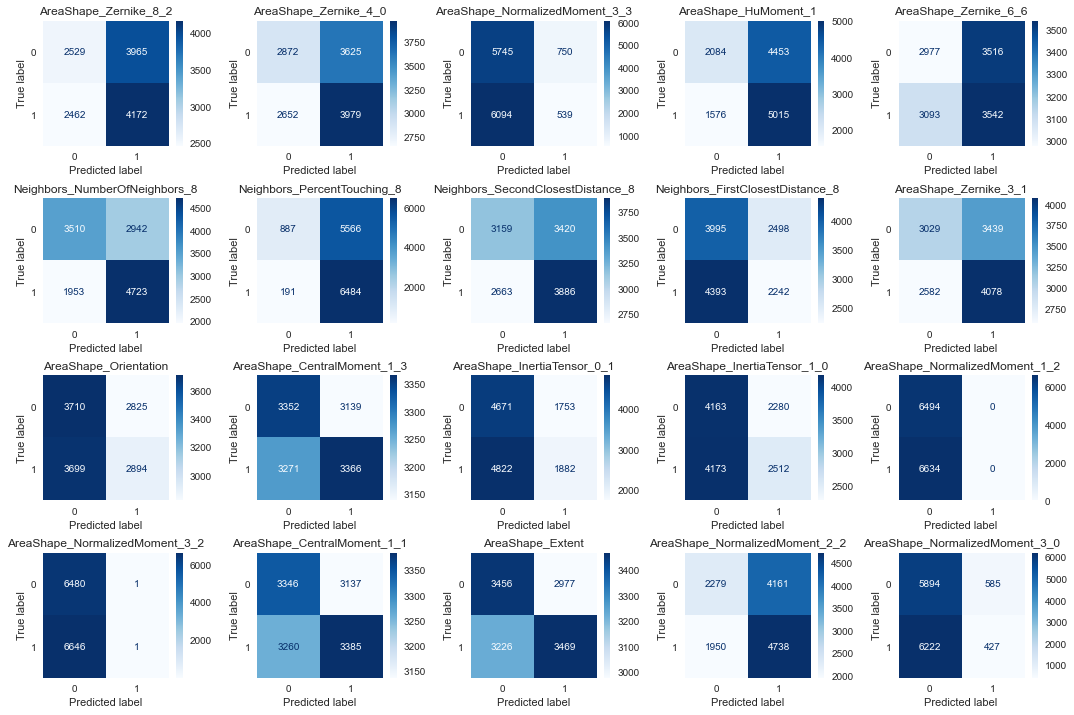

In [27]:
accuracies = {"Spatial parameter":univars, "Cross-validation accuracy":[], "Test accuracy":[]}
n_models = len(univars)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,10))
for n, ax in zip(range(0, n_models), axes.flatten()):
    print(f"VARIABLE: {univars[n]}"+"\n---------------")
    regr, y_pred, y_test, cv_accuracy, y_pred_score = univar_regr(univars[n], labelled_data, new_binary_converter)
    accuracies["Cross-validation accuracy"].append(cv_accuracy)
    accuracies["Test accuracy"].append(y_pred_score)
    print("---------------\n")
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            y_test, 
            y_pred,
        ),
        display_labels=regr.classes_
    ).plot(ax=ax, cmap="Blues")
    ax.grid(False)
    ax.title.set_text(univars[n])
plt.tight_layout()
plt.show()
accuracies_df = pd.DataFrame(data=accuracies)
accuracies_df.to_csv("outputs/var_accuracies_df.csv")